<h1>Sleep and attention</h1>

<h2>An analysis using Repeated-measures Regression models</h2>

In [41]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[1] "sleepstudy-reaction-times"

<h2>Loading the necessary dependencies</h2>

In [42]:
library("ggplot2")  
library("reshape2") 
library("nlme")     

<h2>Exploratory Data Analysis</h2>

<h2>Open the dataset and take a first look at the data</h2>

In [43]:
data <- read.csv("/kaggle/input/sleepstudy-reaction-times/sleepstudy.csv")
head(data)

,X,Reaction,Days,Subject
,<int>,<dbl>,<int>,<int>
1,1,249.5600,0,308
2,2,258.7047,1,308
3,3,250.8006,2,308
4,4,321.4398,3,308
5,5,356.8519,4,308
6,6,414.6901,5,308


In [44]:
summary(data)

       X             Reaction          Days        Subject     
 Min.   :  1.00   Min.   :194.3   Min.   :0.0   Min.   :308.0  
 1st Qu.: 45.75   1st Qu.:255.4   1st Qu.:2.0   1st Qu.:331.0  
 Median : 90.50   Median :288.7   Median :4.5   Median :336.0  
 Mean   : 90.50   Mean   :298.5   Mean   :4.5   Mean   :341.3  
 3rd Qu.:135.25   3rd Qu.:336.8   3rd Qu.:7.0   3rd Qu.:352.0  
 Max.   :180.00   Max.   :466.4   Max.   :9.0   Max.   :372.0  

In [45]:
data$Subject <- factor(data$Subject) 

<h3> We dont want the 'Subject' column as a quantitative variable but as factor</h3>

In [46]:
is.numeric(data$Days)

[1] TRUE

In [47]:
data$Days <- factor(data$Days,
                       levels = c(0:9))

<h3>In this case we will treat the time variable (Days) as quantitative for modelling, but will temporarily use it as factor for better visualizations</h3>

In [48]:
head(data)

,X,Reaction,Days,Subject
,<int>,<dbl>,<fct>,<fct>
1,1,249.5600,0,308
2,2,258.7047,1,308
3,3,250.8006,2,308
4,4,321.4398,3,308
5,5,356.8519,4,308
6,6,414.6901,5,308


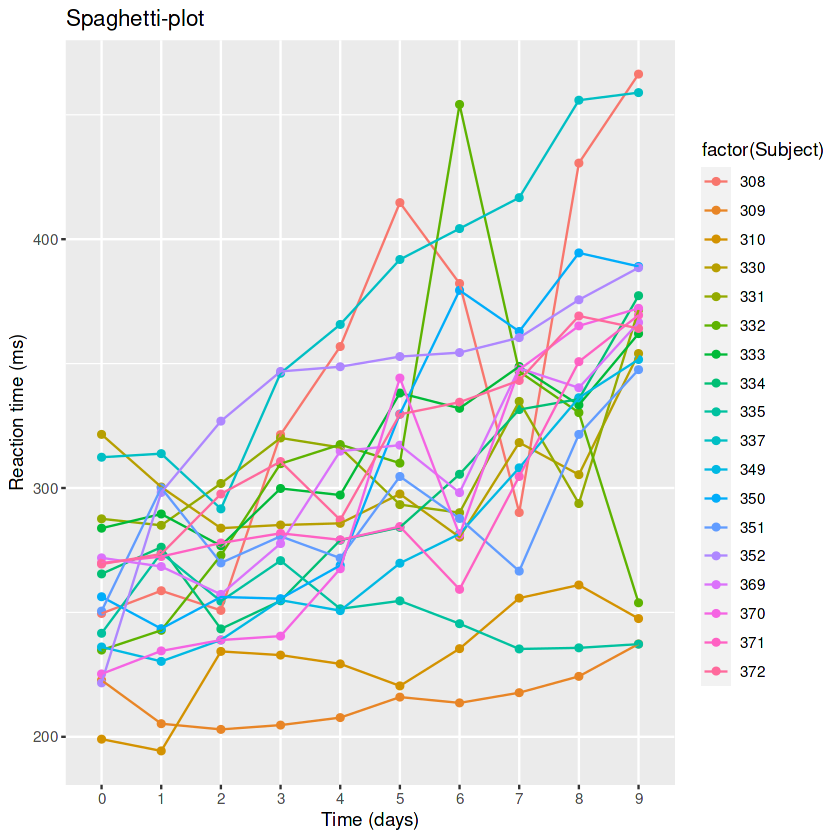

In [49]:
ggplot(data = data, aes(x = Days,
                         y = Reaction,
                         colour = factor(Subject),
                         group = Subject)) +
  labs(title = "Spaghetti-plot",
       x = "Time (days)",
       y = "Reaction time (ms)") +
  geom_point() +
  geom_line()  +
  theme_grey()

Figure 1: Spaghetti-plot showing reactions times across time for all test individuals.

In [50]:
day_mean <- data %>% 
        group_by(Days) %>% 
        summarise(Reaction = mean(Reaction))

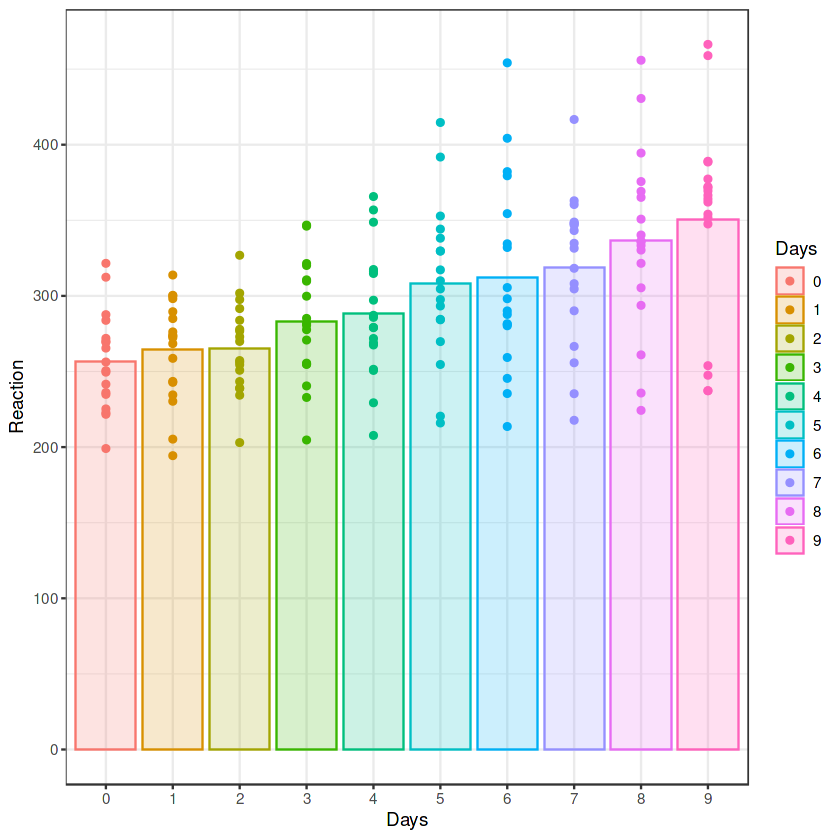

In [51]:
ggplot(data, aes(x = Days, y = Reaction, color=Days, fill=Days)) +
  geom_point() +
  geom_bar(data = day_mean,stat = "identity", alpha = .2) + 
  theme_bw()

Figure 2: Barplot showing mean reactions times across individuals for each day, and measures for all test individuals across all days (points).

In [52]:
data_wide <- dcast(data,
                    formula = Subject ~ Days,
                    value.var = "Reaction")
data_wide

Subject,0,1,2,3,4,5,6,7,8,9
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
308,249.5600,258.7047,250.8006,321.4398,356.8519,414.6901,382.2038,290.1486,430.5853,466.3535
309,222.7339,205.2658,202.9778,204.7070,207.7161,215.9618,213.6303,217.7272,224.2957,237.3142
310,199.0539,194.3322,234.3200,232.8416,229.3074,220.4579,235.4208,255.7511,261.0125,247.5153
330,321.5426,300.4002,283.8565,285.1330,285.7973,297.5855,280.2396,318.2613,305.3495,354.0487
331,287.6079,285.0000,301.8206,320.1153,316.2773,293.3187,290.0750,334.8177,293.7469,371.5811
332,234.8606,242.8118,272.9613,309.7688,317.4629,309.9976,454.1619,346.8311,330.3003,253.8644
333,283.8424,289.5550,276.7693,299.8097,297.1710,338.1665,332.0265,348.8399,333.3600,362.0428
334,265.4731,276.2012,243.3647,254.6723,279.0244,284.1912,305.5248,331.5229,335.7469,377.2990
335,241.6083,273.9472,254.4907,270.8021,251.4519,254.6362,245.4523,235.3110,235.7541,237.2466


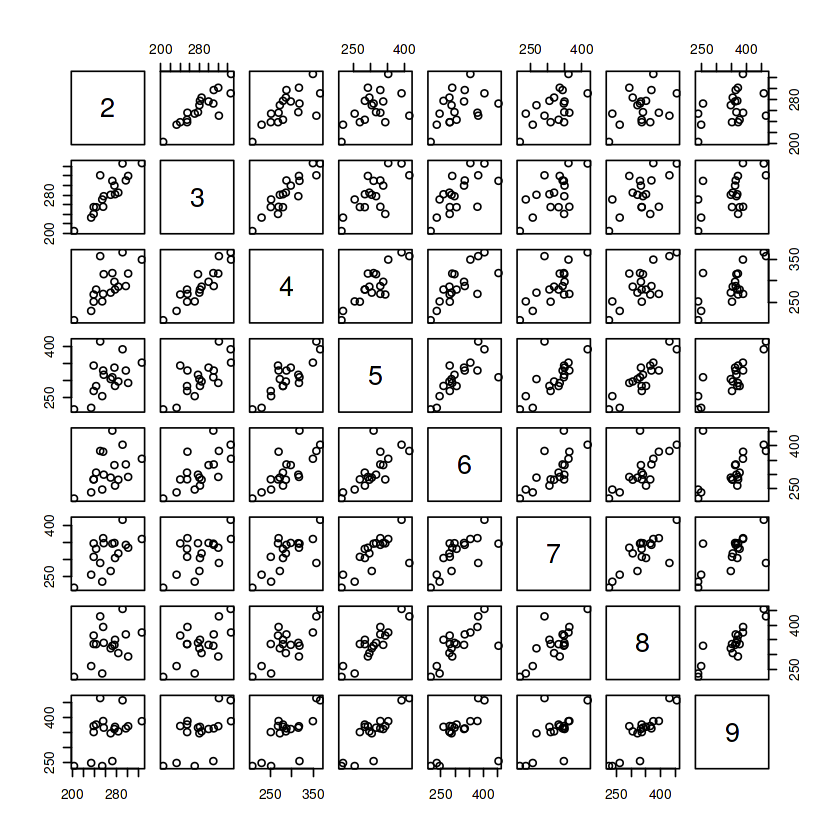

In [53]:
data_c <- data_wide[,4:11]
plot(data_c)

In [54]:
coef_corr <- round(cor(data_c), 2)
coef_corr

,2,3,4,5,6,7,8,9
2,1.00,0.88,0.69,0.49,0.45,0.59,0.41,0.42
3,0.88,1.00,0.91,0.72,0.67,0.60,0.60,0.57
4,0.69,0.91,1.00,0.85,0.75,0.69,0.74,0.72
5,0.49,0.72,0.85,1.00,0.74,0.69,0.90,0.84
6,0.45,0.67,0.75,0.74,1.00,0.70,0.73,0.46
7,0.59,0.60,0.69,0.69,0.70,1.00,0.76,0.66
8,0.41,0.60,0.74,0.90,0.73,0.76,1.00,0.88
9,0.42,0.57,0.72,0.84,0.46,0.66,0.88,1.00


<h3>Correlations matrix for each consecutive day after day 2 (in wich sleep deprivation started).<br/>
Note that the correlation is high at first but gets lower over time (as expected in this type of study).<br>
That also means of course that the measures are not independent, and we will model accordingly.</h3>

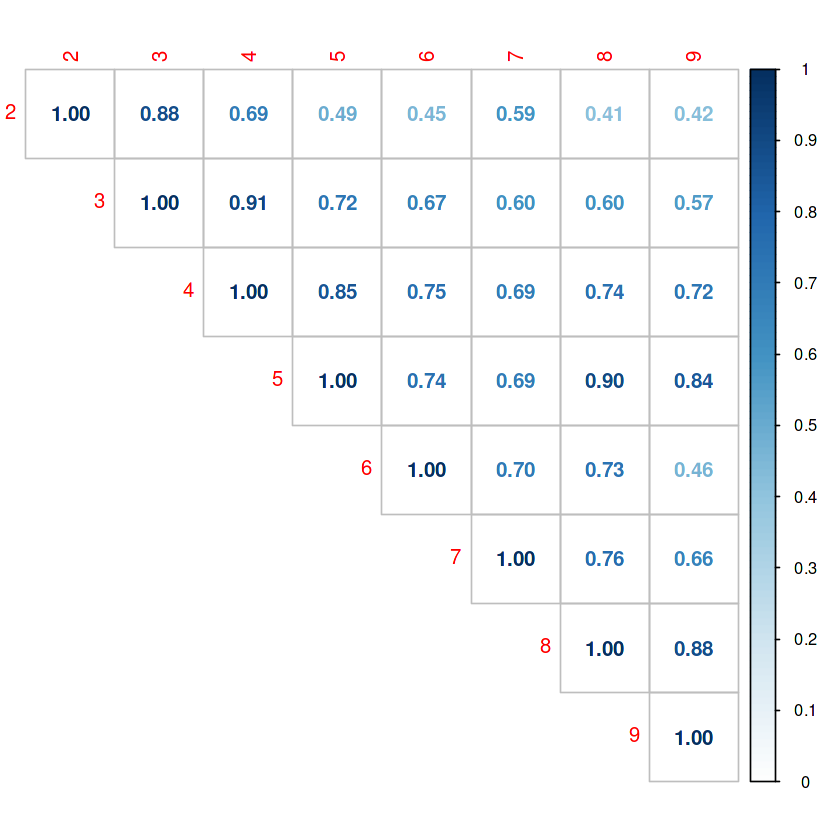

In [55]:
library(corrplot)
corrplot(coef_corr, 
         type = "upper",
         method = "number",
         col.lim = c(0,1))

Figure 3: Correlation matrix.

<h2>Modelling: Linear Regression</h2>

<h3>We will try 3 different models based on repeated-measures design, with 3 different association structure: unstructured correlation, auto-regressive correlation and compound symmetry.</h3>

In [56]:
data <- read.csv("/kaggle/input/sleepstudy-reaction-times/sleepstudy.csv")
data$Subject <- factor(data$Subject)
model1_corCompSymm <- gls(Reaction ~ Days,
                 correlation = corCompSymm(form = ~ 1 | Subject),
                 data = data, subset=Days>=2)

model1_AR1 <- gls(Reaction ~ Days,
                 correlation = corAR1(form = ~ 1 | Subject),
                 data = data, subset=Days>=2)

model1_corSymm <- gls(Reaction ~ Days,
                correlation = corSymm(form = ~ 1 | Subject),
                data = data, subset=Days>=2)

We will write a function that allow us to check the models assumptions of normality and homogeneity of variance. Independency of the measures is not an assumptions this models make as they account for the dependency with the variance association structure.

In [57]:
library(car)
assumptions <- function (model) {
  
  res <- resid(model, type = "pearson")
  pred <- predict(model)
  
  par(mfrow = c(1, 2))
  
  plot(x = pred,
       y = res,
       ylim = c(-4, 4),
       xlab = "Predict",
       ylab = "Pearson Res",
       cex.main = 0.8 )
  
  abline(h = c(-2, 2, 0),
         col = c("red", "red", "black"),
         lty = c(2, 2, 1))
  
  qqPlot(res)
  
  shapiro.test(res)
  
}

In [58]:
head(data)

,X,Reaction,Days,Subject
,<int>,<dbl>,<int>,<fct>
1,1,249.5600,0,308
2,2,258.7047,1,308
3,3,250.8006,2,308
4,4,321.4398,3,308
5,5,356.8519,4,308
6,6,414.6901,5,308



	Shapiro-Wilk normality test

data:  res
W = 0.98243, p-value = 0.062


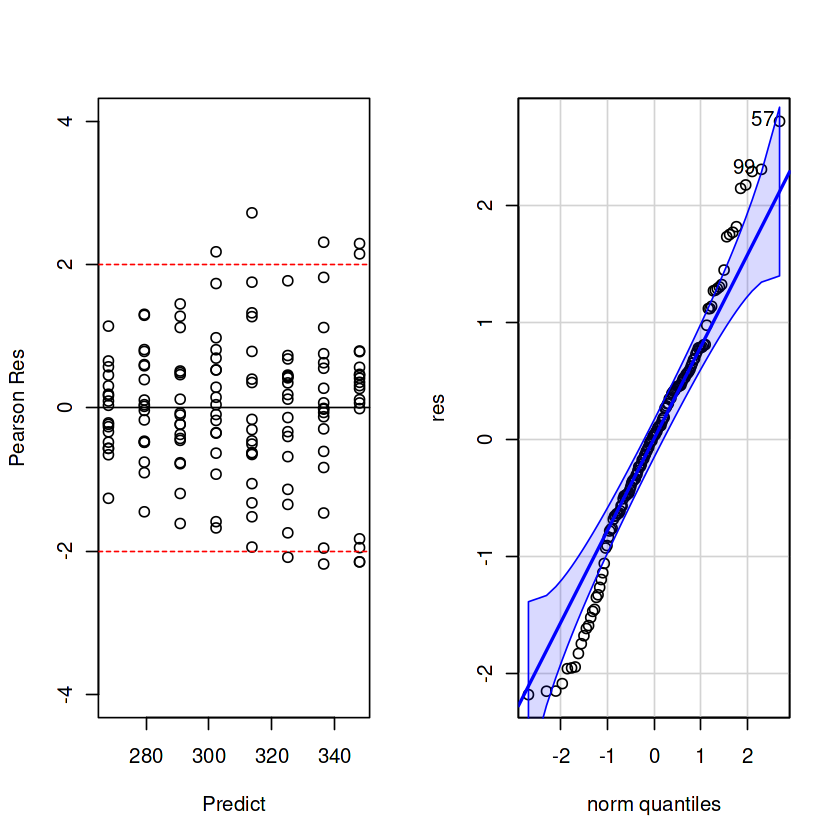

In [59]:
assumptions(model1_corCompSymm)

Figure 4: Assumptions verification for the compound symmetry model. Although it varely passed the Shapiro-Wilk normality test (p=0.06>0.05) in this case there is no homogeneity of variance, as we can see in the residuals plot that the variance gets higher for higher values of the variable. We will model the variance to check if we can solve this problem.


	Shapiro-Wilk normality test

data:  res
W = 0.98636, p-value = 0.1671


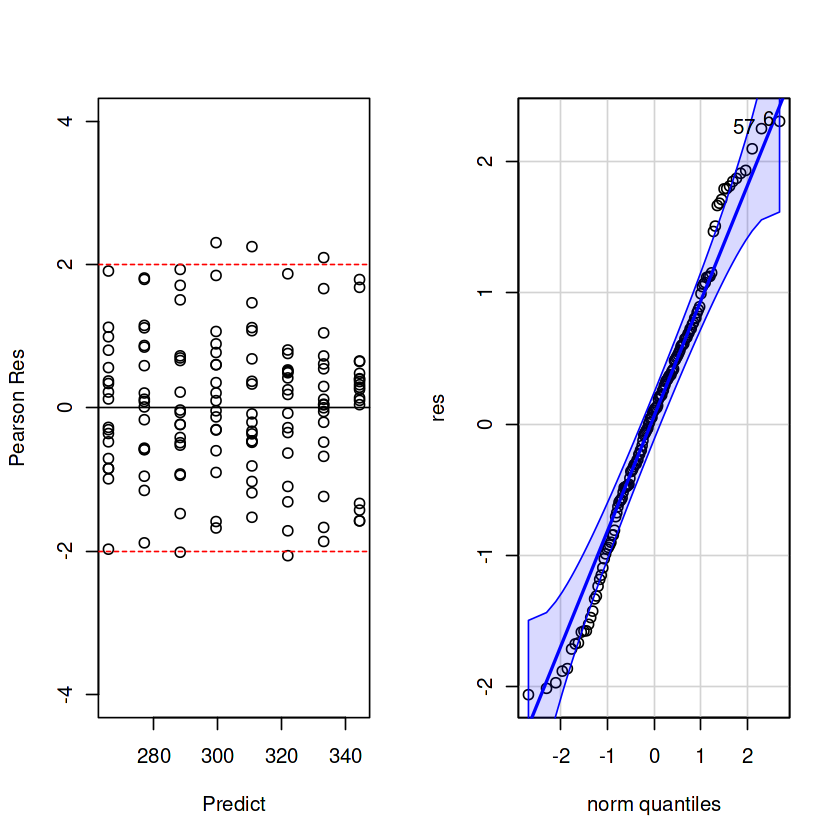

In [60]:
m2<-gls(Reaction ~ Days,
        correlation = corCompSymm(form=~1|Subject),
        weights = varIdent(form = ~ 1 | Days),
        data=data, subset=Days>=2)
assumptions(m2)

Figure 5: Assumptions verification for the compound symmetry model with modelled variance using varIdent structure. Both assumptions were succesfully checked in this case.


	Shapiro-Wilk normality test

data:  res
W = 0.98198, p-value = 0.05525


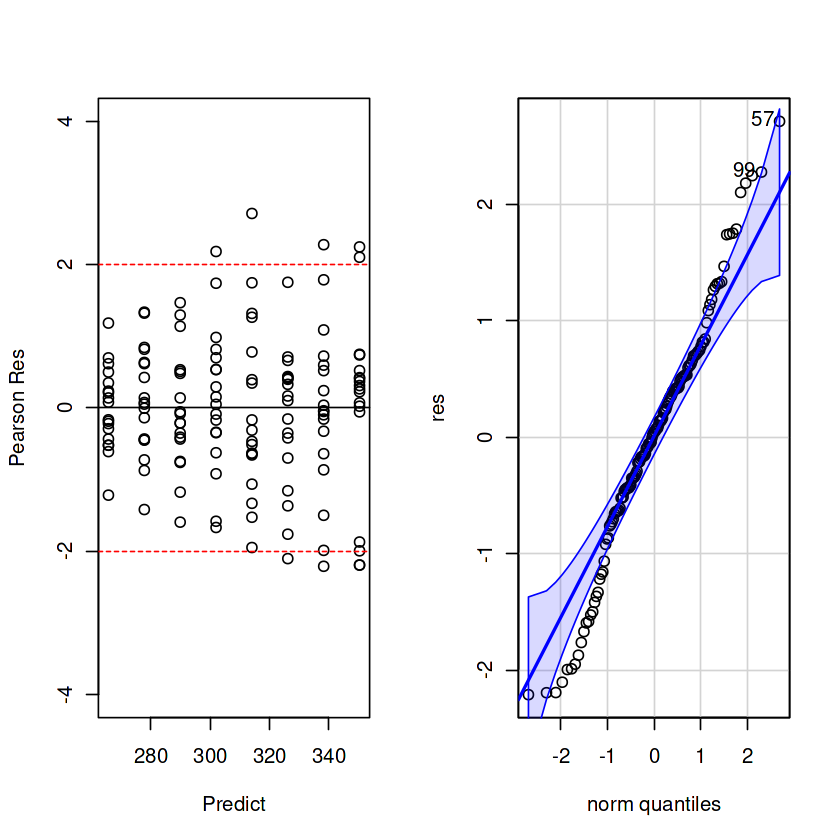

In [61]:
assumptions(model1_AR1)

Figure 6: Assumptions verification for the auto-regressive correlation model. Although in this case the model also varely passed the Shapiro-Wilk normality test (p=0.055>0.050) there is no variance homogeneity.


	Shapiro-Wilk normality test

data:  res
W = 0.98846, p-value = 0.2787


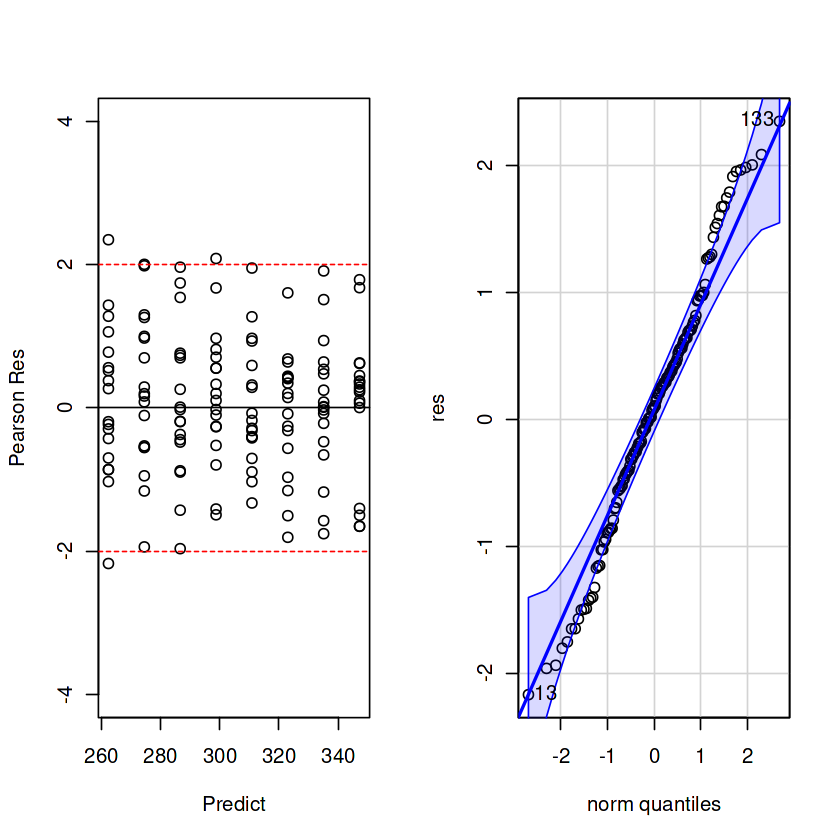

In [62]:
m3<-gls(Reaction ~ Days,
        correlation = corAR1(form=~1|Subject),
        weights = varIdent(form = ~ 1 | Days),
        data=data, subset=Days>=2)
assumptions(m3)

Figure 7: Assumptions verification for the auto-regressive correlation model with modelled variance using varIdent structure. Both assumptions were succesfully checked in this case.



	Shapiro-Wilk normality test

data:  res
W = 0.98199, p-value = 0.05538


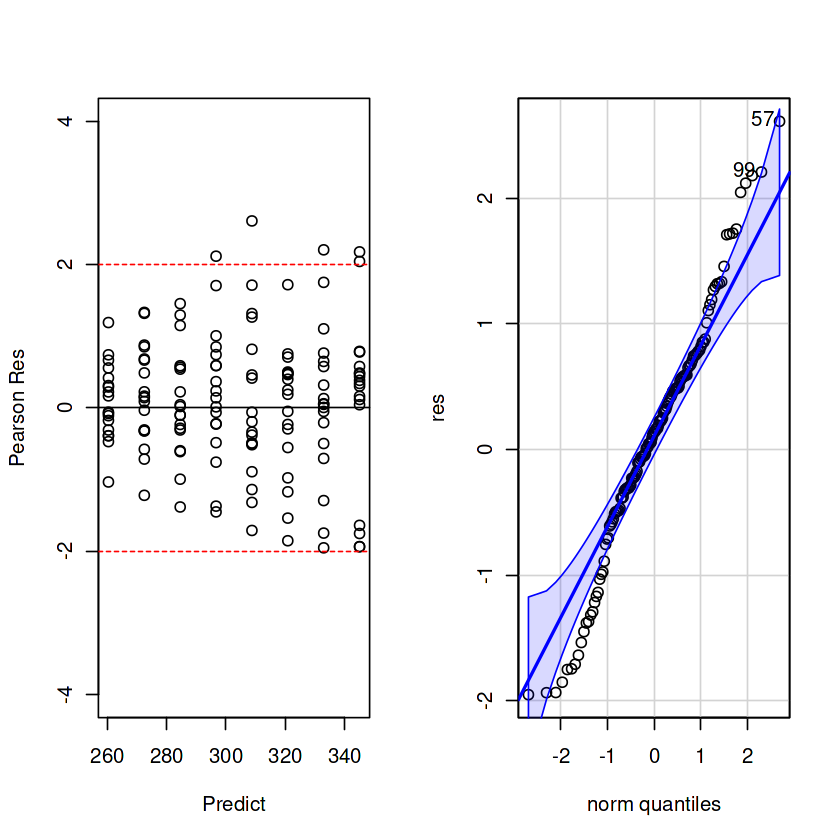

In [63]:
assumptions(model1_corSymm)

Figure 8: Assumptions verification for the unstructered correlation model. Although it varely passed the Shapiro-Wilk normality test (p=0.055>0.050) once again there is no homogeneity of variance.


	Shapiro-Wilk normality test

data:  res
W = 0.98606, p-value = 0.1549


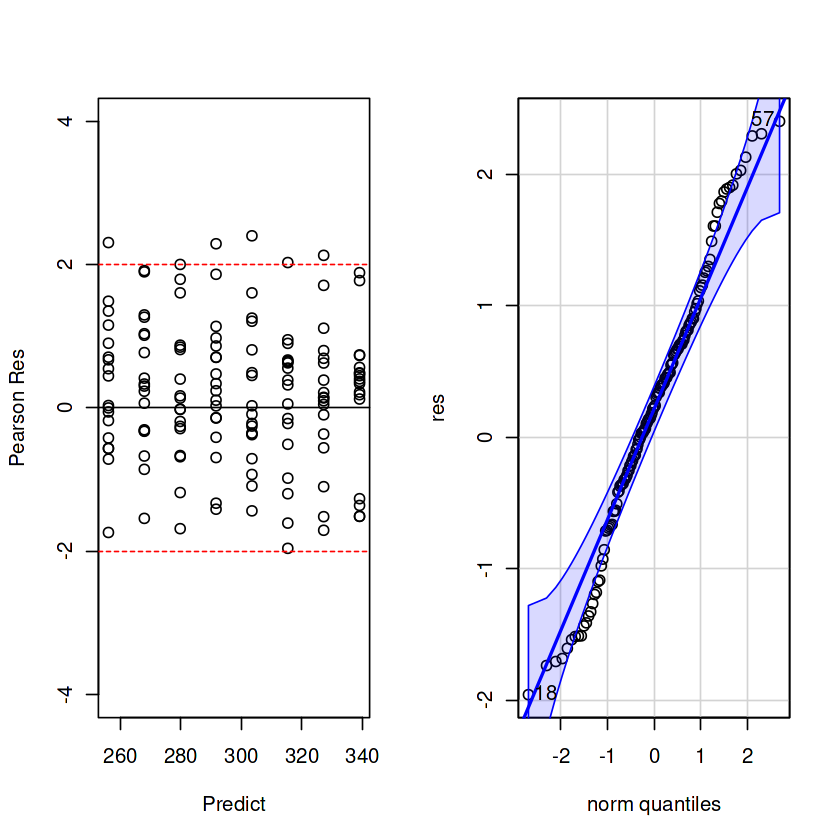

In [64]:
m4<-gls(Reaction ~ Days,
        correlation = corSymm(form=~1|Subject),
        weights = varIdent(form = ~ 1 | Days),
        data=data, subset=Days>=2)
assumptions(m4)

Figure 9: Assumptions verification for the unstructured correlation model with modelled variance using varIdent structure. Both assumptions were succesfully checked in this case.


<h3>Model selection</h3>

In [65]:
AIC(m3,m4,m2)

,df,AIC
,<dbl>,<dbl>
m3,11,1395.744
m4,38,1383.923
m2,11,1423.089


The akaike information criterion (AIC) gives us an estimator of relative quality of statistical models as it rewards for model goodness of fit and penalizes for number of parameters. A lower AIC value means better trade-off between those two dimensions.

In [66]:
selected_model <- m4 #We pick the model with the lowest AIC value
summary(m4)

Generalized least squares fit by REML
  Model: Reaction ~ Days 
  Data: data 
  Subset: Days >= 2 
       AIC      BIC    logLik
  1383.923 1496.244 -653.9614

Correlation Structure: General
 Formula: ~1 | Subject 
 Parameter estimate(s):
 Correlation: 
  1     2     3     4     5     6     7    
2 0.889                                    
3 0.716 0.909                              
4 0.550 0.758 0.861                        
5 0.480 0.678 0.760 0.748                  
6 0.588 0.590 0.701 0.683 0.712            
7 0.441 0.612 0.757 0.895 0.741 0.770      
8 0.459 0.589 0.731 0.841 0.487 0.672 0.889
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | Days 
 Parameter estimates:
       2        3        4        5        6        7        8        9 
1.000000 1.342184 1.399222 1.751690 2.046061 1.628881 1.970827 2.199782 

Coefficients:
                Value Std.Error  t-value p-value
(Intercept) 232.47726  5.647249 41.16646       0
Days         11.851

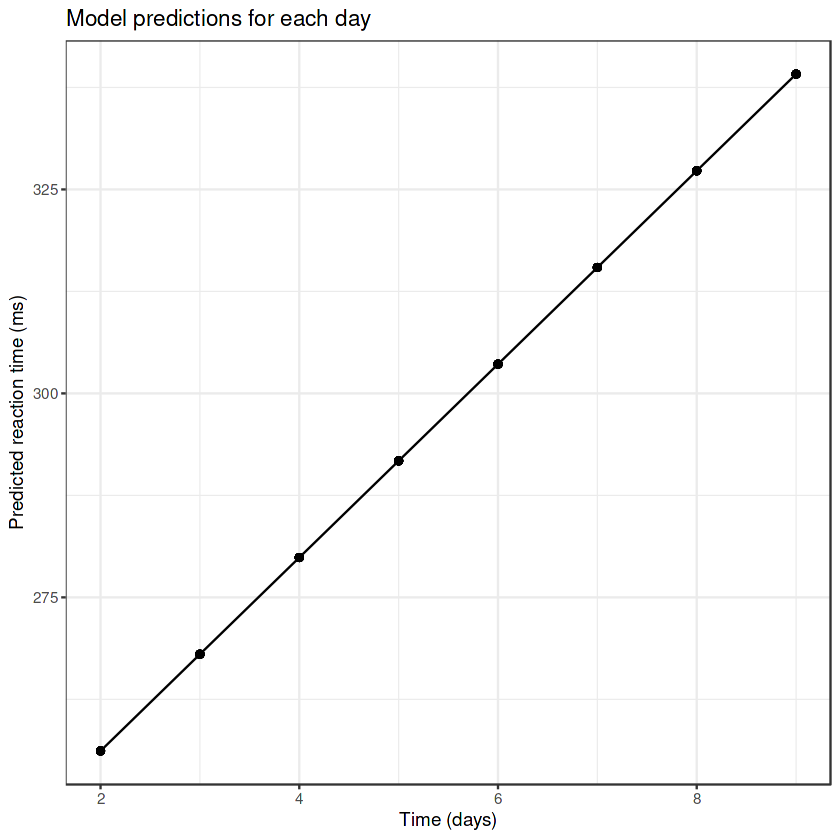

In [67]:
data <- read.csv("/kaggle/input/sleepstudy-reaction-times/sleepstudy.csv")

data3 <- subset(data, Days>=2)
ggplot(data3, aes(x=Days, y= predict(m4))) +
  geom_point() +
  geom_line() +
  labs(title = "Model predictions for each day",
       x = "Time (days)",
       y = "Predicted reaction time (ms)") +
  theme_bw()

Figure 10: Predicted reaction time by the selected model across time.

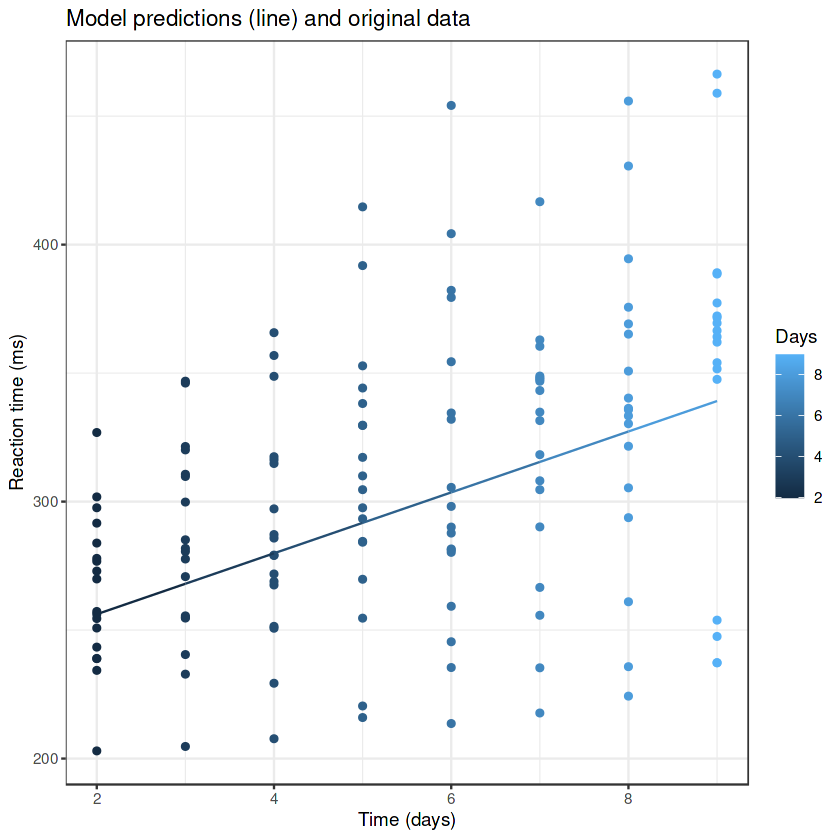

In [68]:
ggplot(data3, aes(x = Days, y = Reaction, color=Days, fill=Days)) +
  geom_point() +
  geom_line(data=data3, aes(x=Days, y= predict(m4))) +  
  labs(title = "Model predictions (line) and original data",
       x = "Time (days)",
       y = "Reaction time (ms)") +
  theme_bw()

Figure 11: Predicted reaction time (line) and original measuments (points) across time.

In [69]:
day_mean <- data3 %>% 
        group_by(Days) %>% 
        summarise(Reaction = mean(Reaction))
day_mean
predict(m4)[0:8]
reduction = predict(m4)[0:1] - predict(m4)[8]
reduction

Days,Reaction
<int>,<dbl>
2,265.3619
3,282.9920
4,288.6494
5,308.5185
6,312.1783
7,318.7506
8,336.6295
9,350.8512


3        4        5        6        7        8        9       10 
256.1794 268.0304 279.8815 291.7325 303.5836 315.4346 327.2857 339.1368

3 
-82.95739

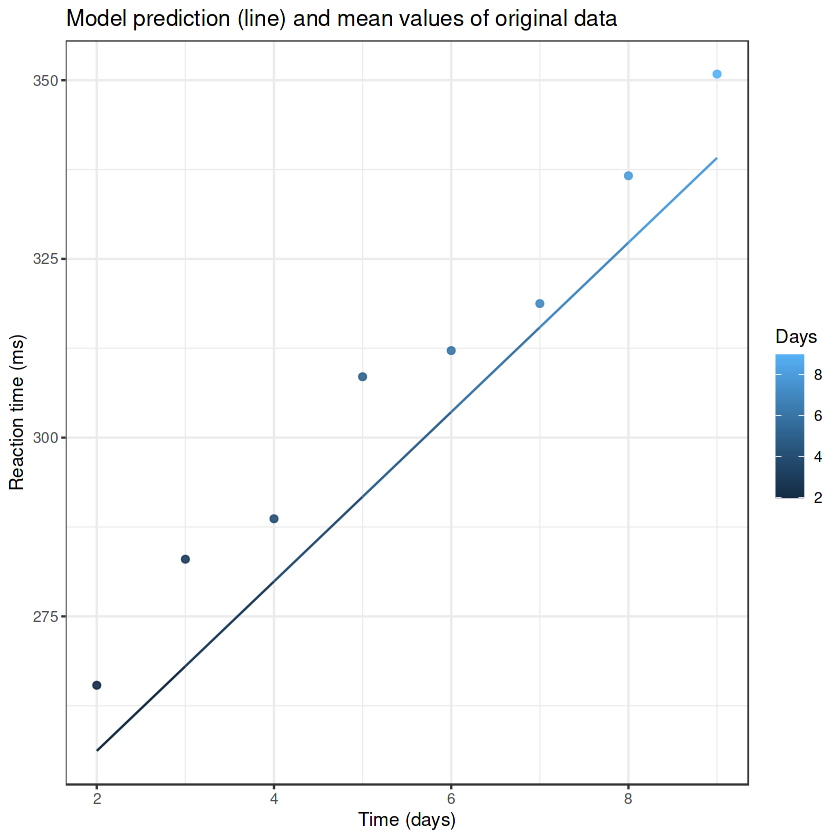

In [70]:
ggplot(data3, aes(x = Days, y = Reaction, color=Days, fill=Days)) +
  geom_point(data = day_mean,stat = "identity", alpha = .9) + 
  geom_line(data=data3, aes(x=Days, y= predict(m4))) +  
  labs(title = "Model prediction (line) and mean values of original data",
       x = "Time (days)",
       y = "Reaction time (ms)") +
  theme_bw()

Figure 12: Predicted reaction time (line) and mean reaction time across individuals for each day.

<h2>Conclusions</h2>

<ul>
  <li>A General Linear Model can be use to model this type of repeated-measures studies, as long as it account for the lack of measures independecy with some type of variance association structure, and (in some cases) the variance is modelled to pass the homogeneity assumption.</li>
    
  <li>Sleep deprivation (3 hours of sleep per day) reduces the reaction time in humans, and that effect is statistically significant.</li>

  <li>After 7 days of sleep deprivation the average individual will experience a 83 ms retardness in their reaction time.</li>
</ul>